# Plot power thresholds

Generic libraries:

In [1]:
from functools import partial
from pathlib import Path
import tomllib

import numpy as np

Other libraries required for this notebook:

In [2]:
from multipac_testbench.src.test_campaign import TestCampaign
import multipac_testbench.src.instruments as ins
from multipac_testbench.src.util.post_treaters import running_mean
from multipac_testbench.src.util.multipactor_detectors import \
    quantity_is_above_threshold

Define the project path, load the configuration.

In [3]:
project = Path("../data/campaign_one_probe/")
config_path = Path(project, "testbench_configuration.toml")

with open(config_path, "rb") as f:
    config = tomllib.load(f)

In [4]:
frequencies = (120., 160.)
swrs = (1., 1.)
filepaths = (
    Path(project, "120MHz_travelling.csv"),
    Path(project, "160MHz_travelling.csv"),
)
test_campaign = TestCampaign.from_filepaths(filepaths,
                                            frequencies,
                                            swrs,
                                            config,
                                            sep='\t')

[WARNING ] [reflection_coefficient.py] 19 points were removed in R calculation, where reflected power was higher than forward power.
[WARNING ] [reflection_coefficient.py] 5 points were removed in R calculation, where reflected power was too close to forward power. Tolerance was: tol = 0.05.
[INFO    ] [factory.py          ] 1 set of global diagnostics defined:
	GlobalDiagnostic global, with instruments: ['ForwardPower (NI9205_Power1)', 'ReflectedPower (NI9205_Power2)', 'ReflectionCoefficient (Reflection_coefficient)', 'SWR (SWR)', 'Frequency (Reference frequency)']
[INFO    ] [factory.py          ] 2 pick-ups created:
[INFO    ] [factory.py          ] 	Pick-Up V2 at z = 0.566m, with instruments: ['Penning (NI9205_Penning1)']
[INFO    ] [factory.py          ] 	Pick-Up E1 at z = 0.611m, with instruments: ['CurrentProbe (NI9205_MP1l)', 'FieldProbe (NI9205_E1)']


Prepare visualisation

In [5]:
figsize = (8, 4)

Smooth the current data

In [6]:
current_smoother = partial(
    running_mean,
    n_mean=10,
    mode='same',
)

test_campaign.add_post_treater(
    current_smoother,
    ins.CurrentProbe,
)

Set a multipactor detection criterion:

In [7]:
current_multipactor_criterions = {'threshold': 16.,
                                  'consecutive_criterion': 10,
                                  'minimum_number_of_points': 5}
current_multipac_detector = partial(quantity_is_above_threshold,
                                    **current_multipactor_criterions)
power_is_growing_kw = {'n_trailing_points_to_check': 70}
current_multipactor_bands = test_campaign.detect_multipactor(
    current_multipac_detector,
    ins.CurrentProbe,
    power_is_growing_kw=power_is_growing_kw,
)

[WARNING ] [filtering.py        ] There was 69 'True' points in the last 70 points of the power growth array. Setting it to False.


<div class="alert alert-block alert-info"><b>Note:</b> Note that for one of the tests, we stopped the experimentation after the start of a new power growth. It messes with the thresholds, as we always take the most conditioned thresholds, *i.e.* the ones that are measured during the last power cycle. Hence we tell the script that the power does not grow again in the last 70 points.</div>

Check that detected multipactor zones are consistent:

[INFO    ] [test_campaign.py    ] Used default gap_in_cm = 1.0955


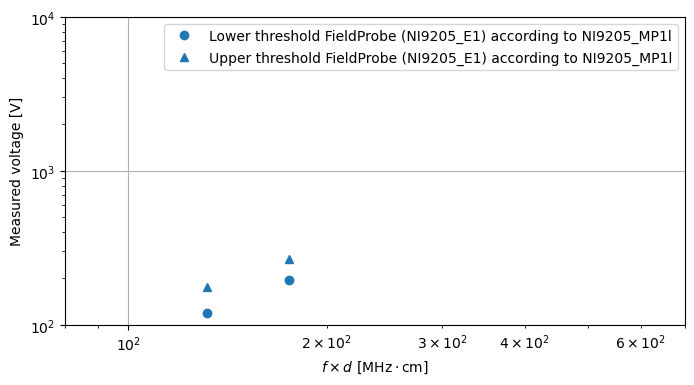

In [8]:
axe, df_susceptibility = test_campaign.susceptibility(
    current_multipactor_bands,
    figsize=figsize,
    xlim=(80., 700.),
    ylim=(1e2, 1e4),
)

<div class="alert alert-block alert-info"><b>Note:</b> It would also work with a test with several electric field probes.</div>